<a href="https://colab.research.google.com/github/mashedpot82/data_analytics_portfolio/blob/main/Diabetes_Classifier_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Data: **Diabetes Dataset**
Source: [Diabetes Dataset](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset

**Description:**
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

**Personal Objectives:**
Demonstrate basic data-exploration, data-cleaning and model training and hyperparameter tuning.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
link = 'https://raw.githubusercontent.com/mashedpot82/data_science_portfolio/main/datasets/diabetes.csv'
Diabetes_DF = pd.read_csv(link)

# Exploring The Data


In [ ]:
Diabetes_DF.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


What immediately stands out to me are the zero values for the **SkinThickness** and **Insulin** columns. A value of 0 for these columns don't make sense and indicate that these are mising values.

Let's check other columns and see if they also have missing values.

In [ ]:
Diabetes_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
print(f'Label Proportions')
percent_diabetics = np.sum(Diabetes_DF['Outcome']==1)/Diabetes_DF.shape[0]
print(f'Percent of Diabetics: {percent_diabetics*100:.2f}%')
print(f'Percent of Non-Diabetics: {100-percent_diabetics*100:.2f}%')

Label Proportions
Percent of Diabetics: 34.90%
Percent of Non-Diabetics: 65.10%


The Ratio of Diabetics to Non-Diabetics in this dataset is roughly 35/65 which means that our data is not imbalanced. It is therefore not necessary to use imbalanced data-set techniques on our dataset.

In [ ]:
Diabetes_DF.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Minimum values of 0 for **Glucose**, **BloodPressure**, **SkinThickness**, **Insulin** and **BMI** don't make sense which indicates that that there are missing values in these colums. We'll deal with these missing values later.

## Data Cleaning
What would be the most effective way to handle missing data? We can either:


1.   Remove the data altogether (row/column removal)
2.   Impute or replace the data

First we need to count the missing data from the 5 columns



In [ ]:
Diabetes_New_DF = Diabetes_DF.copy(deep = True)
Diabetes_New_DF[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] \
= Diabetes_New_DF[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

print(Diabetes_New_DF.isna().sum())
Percent_InsulinData = 100-Diabetes_New_DF['Insulin'].isna().sum()/Diabetes_New_DF.shape[0]*100
print(f'Percentage of Insulin Data available: {Percent_InsulinData:.2f}%')


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Percentage of Insulin Data available: 51.30%


Since 51.3% of the Insulin Data is available, we can opt to keep the feature/column (feature removal is only recommended for 75% missing data). Removing the rows might not be a good idea since close to half of the data will only be used for prediction which might not be enough. This leaves us with imputation.

### What Imputation Method should we use?
The simplest imputation methods are mean/median/mode imputation to find which of these methods are most suitable, let's take a look at the distrubutions of the data

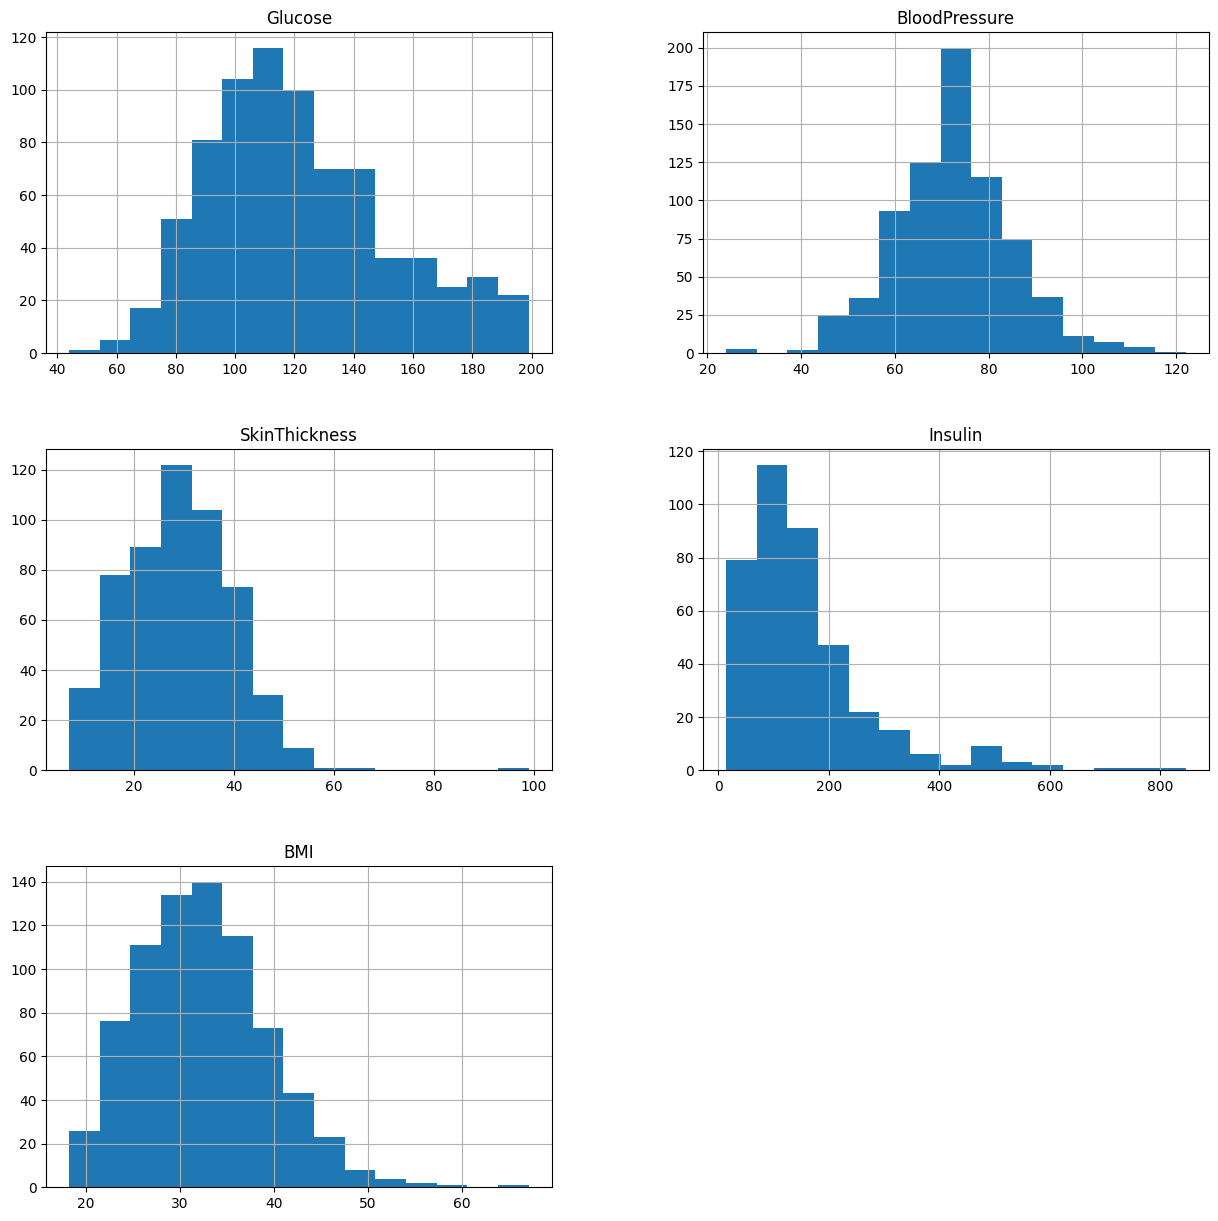

In [ ]:
p = Diabetes_New_DF[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].hist(figsize = (15,15), bins = 15)

Using the eye test -- **Glucose**, **Insulin** and **BMI** seem to be skewed *while* **SkinThickness** and **BloodPressure** are roughly normally distributed. We will therefore use Median Imputation on the former features and Mean Imputation on the latter.

In [ ]:
Median_Glucose = Diabetes_New_DF['Glucose'].median()
Median_Insulin = Diabetes_New_DF['Insulin'].median()
Median_BMI = Diabetes_New_DF['BMI'].median()
Mean_SkinThickness = Diabetes_New_DF['SkinThickness'].mean()
Mean_BloodPressure = Diabetes_New_DF['BloodPressure'].mean()

Diabetes_New_DF['Glucose'].fillna(Median_Glucose, inplace = True)
Diabetes_New_DF['Insulin'].fillna(Median_Insulin, inplace = True)
Diabetes_New_DF['BMI'].fillna(Median_BMI, inplace = True)
Diabetes_New_DF['SkinThickness'].fillna(Mean_SkinThickness, inplace = True)
Diabetes_New_DF['BloodPressure'].fillna(Mean_BloodPressure, inplace = True)

/tmp/ipython-input-2331941847.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Diabetes_New_DF['Glucose'].fillna(Median_Glucose, inplace = True)
/tmp/ipython-input-2331941847.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

####Plotting After Imputation

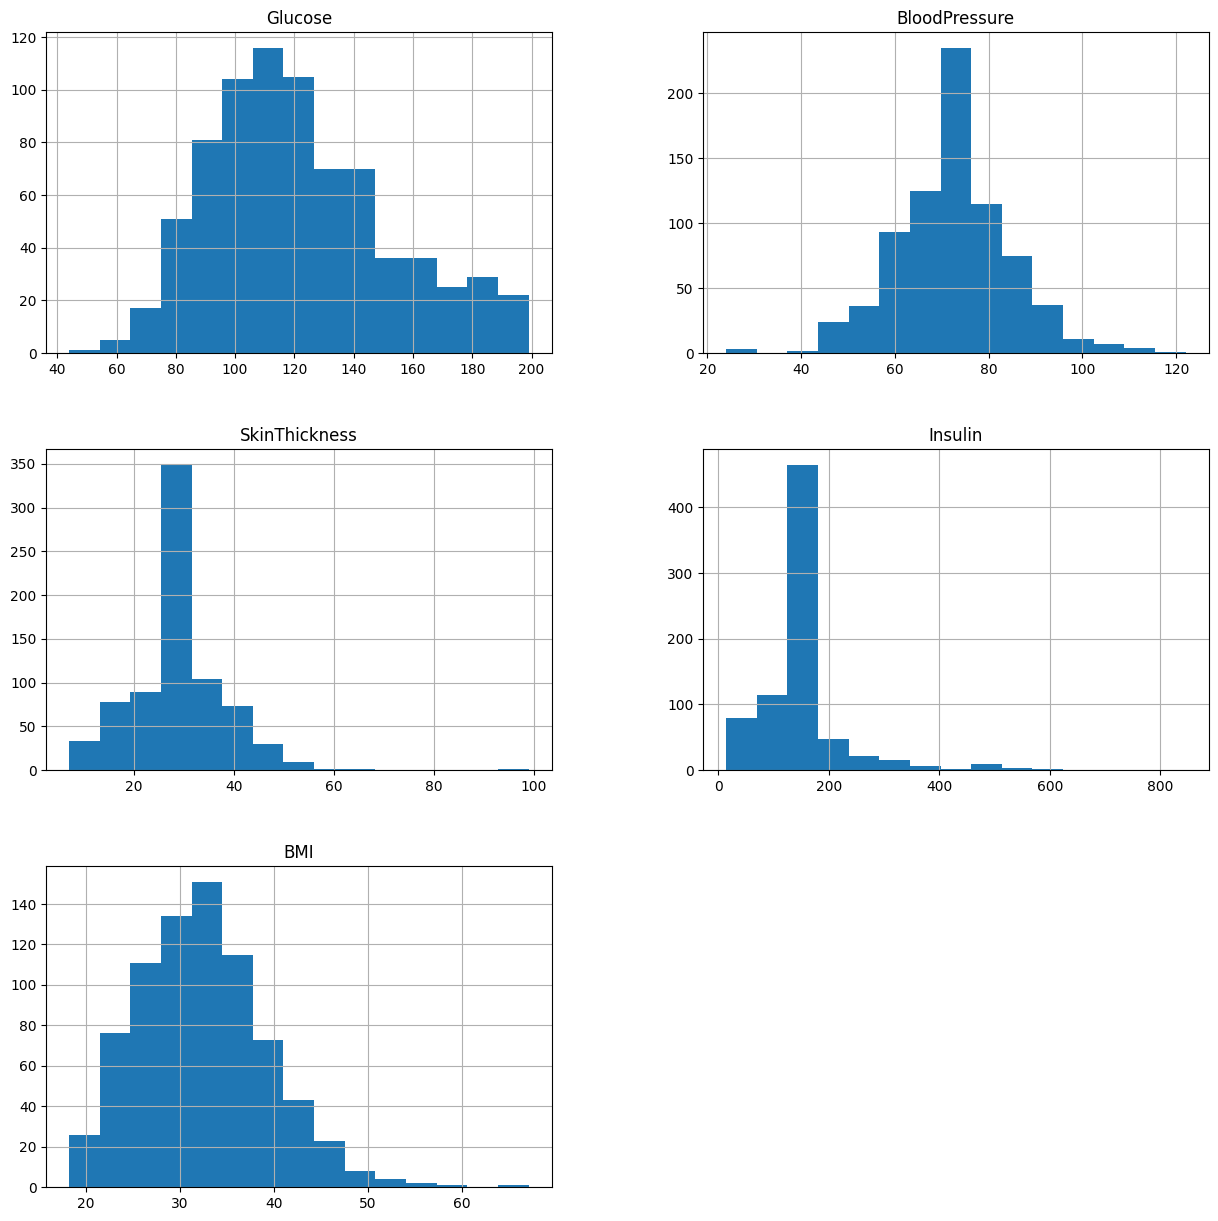

In [ ]:
P = Diabetes_New_DF[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].hist(figsize = (15,15), bins = 15)


# Creating a Machine Learning Model
The goal of this model is to predict whether someone has Diabetes or not given the following features: No. of pregnancies, Blood Pressure, Glucose, Skin Thickness,Insulin, BMI, Diabetes Pedigree Function, and Age              

## Splitting the Data


In [ ]:
from sklearn.model_selection import train_test_split
X, y= Diabetes_New_DF.iloc[:, 0:7], Diabetes_New_DF.iloc[:, 8]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.2, random_state=42, stratify = y)

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (614, 7)
y_train Shape: (614,)
X_test Shape: (154, 7)
y_test Shape: (154,)


## Model Training and Hyperparameter tuning
Now that we've divided the data into train, test and validation splits. We need to figure out which model/models to use.

From the outcomes, we know that this is a binary classification problem. Thus we need to select an ML algorithm that can handle binary classification.

We would then need to select suitable hyperparameters for that chosen model. To aid us in doing so, we will use K-fold cross validation (embedded in sklearn's GridSearchCV) on the training set.

For this project, I'll be using XGboost's Gradient Boosting as the model. The hyper-parameter's we will be modifying are:
max_depth, learning rate, and the number of estimators


---





In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#Hyperparameter options for our boosted tree
param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000, 2000],
}

clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, cv = 5, scoring = 'f1')
grid_search.fit(X_train, y_train)
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2000}
Best score:  0.6202173597032113


Now that we've found out the best hyperparameters, we'll be (re-)training our data on the training set using the best set of hyperparameters.

In [ ]:
clf_final = xgb.XGBClassifier(max_depth = 3,
                              learning_rate = 0.001,
                              n_estimators = 1000,
                              random_state = 42)
clf_final.fit(X_train, y_train)
preds = clf_final.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print(f'Test Accuracy: {accuracy:2f}')
total_correct_preds = np.sum(preds==y_test)
print(f"Total Correct Predictions: {total_correct_preds}")

train_acc = float(np.sum(clf_final.predict(X_train)==y_train))/y_train.shape[0]
print(f'Training Accuracy: {train_acc}')

Test Accuracy: 0.707792
Total Correct Predictions: 109
Training Accuracy: 0.7752442996742671


The training accuracy is slightly higher than the test accuracy which might indicate overfitting.

Training Accuracy might not be the best metric to test our data. Often, for screening diseases, false positive and false negative rates are important. Though it is ideal for both false positive and false negative rates to be low-- for deadly diseases, it is imperative for the false negative rates in particular to be low. This is because a high false negative rate means that more people who actually have the disease have been misdiagnosed to not have the disease. This means that they would not be getting the treatment that is necessary for their disease. A high false positive rate in this case is okay because we could later change the diagnosis once additional treatments/screening procedures have been created.

Illustrated below is the confusion matrix for this classifier: which highlights the false positive and false negative rates of our model.




<Axes: >

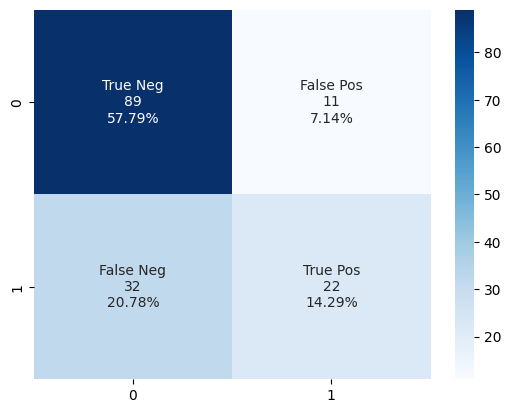

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
c_matrix = confusion_matrix(y_test, preds)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten()/np.sum(c_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')


## Final Words and Conclusion
Our final test accuracy is 72.08% which means there's a lot more room for improvement. We can also see from the confusion matrix above that the False Negative rate is high (20.78%). For this we can explore other machine learning algorithms  or experiment with other hyperparameter combinations to see if the test accuracy improves.

This notebook has already served it's purpose for me, which is to demo XGBoost and increase my understanding on the basics of XGBoost. I also got to showcase a bit of data exploration, data cleaning, and Hyperparameter Tuning. Overall, I learned a lot from this simple project!